<a href="https://colab.research.google.com/github/sunny-5555/Computer-Vision-Assignments/blob/add-notebooks/a3-objectClassification/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Vision - Assignment 3: Object classification with HoG/SVM and Multilayer Perceptrons using public datasets

---

Prof. Dr. Markus Enzweiler, Esslingen University of Applied Sciences

markus.enzweiler@hs-esslingen.de

---

This is the third assignment for the "Machine Vision" lecture. 
It covers:
* training a pedestrian classifier using HoG features and linear SVM classifiers 
* training a neural network (MLP) to categorize an image into 1 out of 10 categories
* working with public benchmark datasets ([Daimler Pedestrian Detection Benchmark](https://markus-enzweiler.de/datasets/) and [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html))

**Make sure that "GPU" is selected in Runtime -> Change runtime type**

To successfully complete this assignment, it is assumed that you already have some experience in Python and numpy. You can either use [Google Colab](https://colab.research.google.com/) for free with a private (dedicated) Google account (recommended) or a local Jupyter installation.

---


## Preparations


### Import important libraries (you should probably start with these lines all the time ...)

In [3]:
# OpenCV
import cv2   

# NumPy                    
import numpy as np   

# glob
import glob # glob

# Matplotlib    
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# make sure we show all plots directly below each cell
%matplotlib inline 

# Some Colab specific packages
if 'google.colab' in str(get_ipython()):
  # image display
  from google.colab.patches import cv2_imshow 


# scikit learn for SVM (support vector machines)
from sklearn import svm


### Some helper functions that we will need

In [4]:
def my_imshow(image, windowTitle="Image"):
  '''
  Displays an image and differentiates between Google Colab and a local Python installation. 

  Args: 
    image: The image to be displayed

  Returns:
    - 
  '''

  if 'google.colab' in str(get_ipython()):
    cv2_imshow(image)
  else:
    cv2.imshow(windowTitle, image)

### In Google Colab only:
Mount the Google Drive associated with your Google account. You will have to click the authorization link and enter the obtained authorization code here in Colab. 

In [7]:
# Mount Google Drive
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### If you are not using Google Colab:
Just store the image in the same folder as your Jupyter notebook file.

## Exercise 1 - Pedestrian Classification using HoG / linear SVM (10 points) 

In this exercise you will be developing a pedestrian classifier based on the famous ["Histograms of Oriented Gradients (HoG) for Human Detection" approach](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf). The dataset you will be using is the public ["Daimler Pedestrian Detection dataset"](http://www.dariu.net/pami09.pdf) which is available in *pedestrianData.zip*.  

For HoG features, you will be using OpenCV, e.g. the *HOGDescriptor* class in *cv2*. Hint: Use ```help(cv2.HOGDescriptor()``` to view the documentation. Linear Support Vector Machines to train in the HoG feature spaces are available via [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC). 

### Unzip the dataset. It provides 9800 labeled images for training and 9800 labeled images for testing. (**PROVIDED**)

In [9]:
################ Unzip the dataset in the Colab runtime #################
import zipfile

url = 'https://raw.githubusercontent.com/sunny-5555/Computer-Vision-Assignments/main/a3-objectClassification/data/pedestrianData.zip'

response = requests.get(url, allow_redirects = True)
stream = io.BytesIO(response.content)

print("unzipping {}".format(url))

with zipfile.ZipFile(stream, 'r') as zip_ref:
    zip_ref.extractall("pedestrian")

# Only uncomment if data is stored on Google Drive, pathToZip needs to be changed
#pathToZip = 'a3-objectClassification/data/pedestrianData.zip'
#print("unzipping {}".format(pathToZip))
#with zipfile.ZipFile(pathToZip, 'r') as zip_ref:
#    zip_ref.extractall("pedestrian")

# training images
trainPed    = glob.glob('pedestrian/data/train/ped_examples/' + "*.pgm")
trainNonPed = glob.glob('pedestrian/data/train/non-ped_examples/' + "*.pgm")

# test images
testPed     = glob.glob('pedestrian/data/test/ped_examples/' + "*.pgm")
testNonPed  = glob.glob('pedestrian/data/test/non-ped_examples/' + "*.pgm")

print("trainPed    : {} image paths".format(len(trainPed)))
print("trainNonPed : {} image paths".format(len(trainNonPed)))
print("testPed     : {} image paths".format(len(testPed)))
print("testNonPed  : {} image paths".format(len(testNonPed)))

unzipping https://raw.githubusercontent.com/sunny-5555/Computer-Vision-Assignments/main/a3-objectClassification/data/pedestrianData.zip
trainPed    : 4800 image paths
trainNonPed : 5000 image paths
testPed     : 4800 image paths
testNonPed  : 5000 image paths


### Visualize a few images to get a feeling for what the data looks like (**PROVIDED**)

Random pedestrians


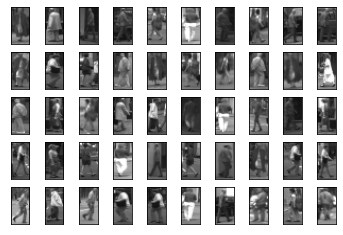

Random non-pedestrians


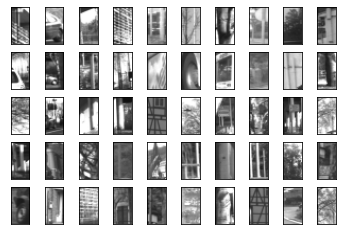

In [ ]:
def displayRandomImages(dataSet):
  indices = np.arange(len(dataSet))
  np.random.shuffle(indices)
  count=0
  for i in indices[0:50]:
      plt.subplot(5,10,count+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      sampleImage = cv2.imread(dataSet[i])   
      plt.imshow(sampleImage)
      count = count+1
  plt.show()


# display some pedestrians
print("Random pedestrians")
displayRandomImages(trainPed)

# display some non-pedestrians
print("Random non-pedestrians")
displayRandomImages(trainNonPed)

### HoG feature transform (**add your code here**)

Compute HoG features using OpenCV's ```cv2.HOGDescriptor.compute()``` function for all 4 image sets (trainPed, trainNonPed, testPed, testNonPed). Use the following parameters for HoG:

* ```winSize = (18,36)```
* ```blockSize = (6,6)```
* ```blockStride = (3,3)```
* ```cellSize = (3,3)```
* ```nbins = 12```

The result should be a 2640 dimensional HoG feature vector for every 18x36 pixel input image. Store the HoG feature representation in 4 matrices (one per image set) with the shape: numImages (rows) x featureDimension (cols). You will need to transpose the output of ```cv2.HOGDescriptor.compute()``` to make it a column vector. 

Your result should be four matrices of size 4800(5000) x 2640.  

Hint: The [C++ documentation of HOGDescriptor()](https://docs.opencv.org/master/d5/d33/structcv_1_1HOGDescriptor.html#a5c8e8ce0578512fe80493ed3ed88ca83) might be helpful ...

In [ ]:
# apply HoG feature transform to the 4 image sets


# --------------------------------------------------#
def applyHogTransform(imageSet, hogDescriptor):

  # feature dimension
  hogDim = hogDescriptor.getDescriptorSize()

  # numImages x featureDimension
  hogFeatureSet = np.zeros((len(imageSet), hogDim))

  # loop through the imageSet and compute HoG features for each image
  for iImageSet in range(len(imageSet)):
    
    # read image
    iImage = cv2.imread(imageSet[iImageSet])        

    # compute HoG features
    hogFeatureSet[iImageSet] = hogDescriptor.compute(iImage).T
  
  print("Shape of feature matrix: {}".format(hogFeatureSet.shape))
  return hogFeatureSet
# --------------------------------------------------#

# create an instance of cv2.HOGDescriptor with the given parameters
hogDescriptor = cv2.HOGDescriptor((18,36),(6,6),(3,3),(3,3),12)

# apply transform to all four image sets
trainPedHogFeatures    = applyHogTransform(trainPed,    hogDescriptor)
trainNonPedHogFeatures = applyHogTransform(trainNonPed, hogDescriptor)
testPedHogFeatures     = applyHogTransform(testPed,     hogDescriptor)
testNonPedHogFeatures  = applyHogTransform(testNonPed,  hogDescriptor)

Shape of feature matrix: (4800, 2640)
Shape of feature matrix: (5000, 2640)
Shape of feature matrix: (4800, 2640)
Shape of feature matrix: (5000, 2640)


### Linear SVM Training (**add your code here**)

Train a linear support vector machine on the HoG representation of trainPed and trainNonPed using  [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC). Set the "C" parameter to ```C=0.1```. 

Training a linear SVM (see [svm.LinearSVC.fit()](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.fit)) requires the **whole** training set (trainPedHogFeatures and trainNonPedHogFeatures) as a single matrix. Browse through [svm.LinearSVC.fit()](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.fit) to find out on how to concatenate the data. 

Additionally, a vector of target class labels is required. Use the label ```1```for pedestrian samples and ```-1```for non-pedestrian samples. Hint: ```np.concatenate()``` and ```np.full()``` might come in handy ...



In [ ]:
# Linear SVM Training

# create instance of LinearSVC
linSVM = svm.SVC(kernel='linear',C=0.1)
# training data
X = np.concatenate((trainPedHogFeatures,trainNonPedHogFeatures), axis=0)

# labels for the training data
yLabelPed = np.full((len(trainPedHogFeatures),1),1)
yLabelNonPed = np.full((len(trainNonPedHogFeatures),1),-1)
y_vec = np.concatenate((yLabelPed,yLabelNonPed),axis=0)
y = np.ravel(y_vec)

# train SVM
linSVM.fit(X,y)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Evaluate Your HoG / SVM Classifier (**add your code here**)

Use [svm.LinearSVC.score()](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.score) to compute the mean accuracy of your classifier on the training set and on the test set, both in the HoG feature space. 

Your classifier should reach approximately 99.4% accuracy on the training set and 75.4% accuracy on the test set.


In [ ]:
# get score on training set
# ...
meanAccuracy = linSVM.score(X,y) * 100
print("Mean accuracy (training set) = {}%".format(meanAccuracy))


# get score on test set
# ...
# test data
X_test = np.concatenate((testPedHogFeatures,testNonPedHogFeatures), axis=0)

# labels for the training data
yLabelTestPed = np.full((len(testPedHogFeatures),1),1)
yLabelTestNonPed = np.full((len(testNonPedHogFeatures),1),-1)
y_vec_test = np.concatenate((yLabelTestPed,yLabelTestNonPed),axis=0)
y_test = np.ravel(y_vec_test)
meanAccuracy = linSVM.score(X_test,y_test) * 100
print("Mean accuracy (test set) = {}%".format(meanAccuracy))

Mean accuracy (training set) = 98.33673469387755%
Mean accuracy (test set) = 77.08163265306123%


### Find the best and worst predictions of your HoG / SVM classifier (**PROVIDED**)



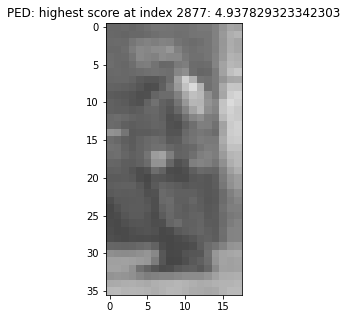

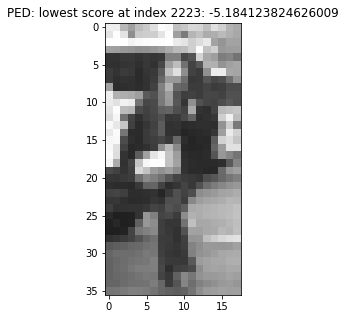

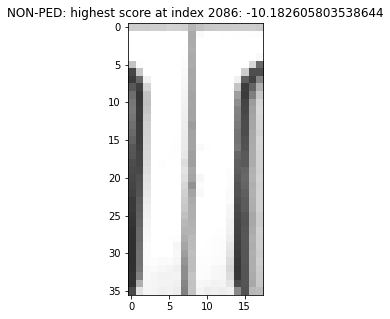

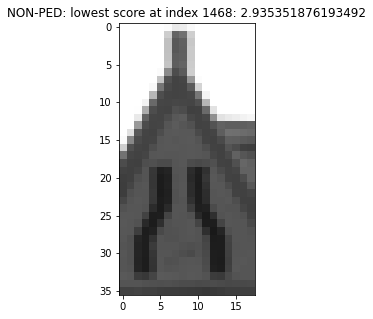

In [ ]:
# find the pedestrian test sample with the highest SVM prediction score
predictions = linSVM.decision_function(testPedHogFeatures)
bestIndex = np.argmax(predictions)
sampleImage = cv2.imread(testPed[bestIndex])  
plt.figure(figsize=(10,5))
plt.imshow(sampleImage, cmap='gray') 
plt.title("PED: highest score at index {}: {}".format(bestIndex, predictions[bestIndex]));

# find the pedestrian test sample with the lowest SVM prediction score
worstIndex = np.argmin(predictions)
sampleImage = cv2.imread(testPed[worstIndex])  
plt.figure(figsize=(10,5))
plt.imshow(sampleImage, cmap='gray') 
plt.title("PED: lowest score at index {}: {}".format(worstIndex, predictions[worstIndex]));

# find the non-pedestrian test sample with the highest SVM prediction score
predictions = linSVM.decision_function(testNonPedHogFeatures)
bestIndex = np.argmin(predictions)
sampleImage = cv2.imread(testNonPed[bestIndex])  
plt.figure(figsize=(10,5))
plt.imshow(sampleImage, cmap='gray') 
plt.title("NON-PED: highest score at index {}: {}".format(bestIndex, predictions[bestIndex]));

# find the non-pedestrian test sample with the lowest SVM prediction score
worstIndex = np.argmax(predictions)
sampleImage = cv2.imread(testNonPed[worstIndex])  
plt.figure(figsize=(10,5))
plt.imshow(sampleImage, cmap='gray') 
plt.title("NON-PED: lowest score at index {}: {}".format(worstIndex, predictions[worstIndex]));

## Exercise 2 - CIFAR-10 Classification using Multilayer Perceptrons in TensorFlow / Keras (10 points)

In this exercise you will train a multilayer perception neural network using TensorFlow and Keras on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. There will be no previous feature transform, i.e. the raw pixel values are the input to the neural network. Adam will be used as optimizer. 

[Keras](https://keras.io/) is a high-level API built on top of TensorFlow that provides an easier API to the training of neural networks in comparison to plain TensorFlow.  

### Some more imports


In [ ]:
# TensorFlow and Keras
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Flatten, Dense
from keras.optimizers import Adam

### Getting familiar with the CIFAR-10 dataset (**PROVIDED**)

170500096/170498071 [==============================] - 2s 0us/step


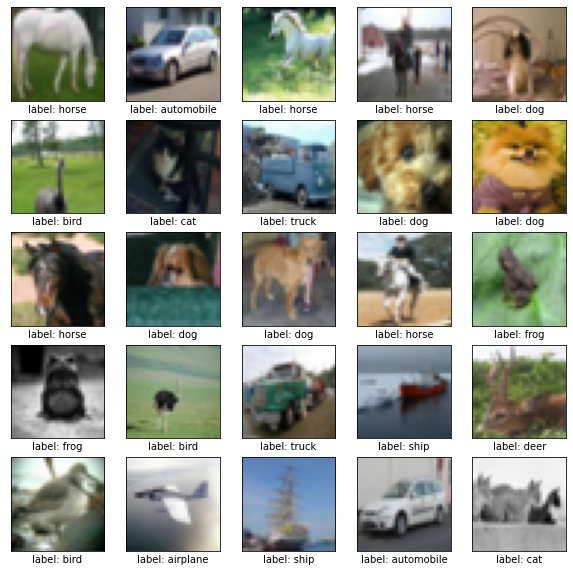

In [ ]:
# CIFAR-10 is available as standard dataset in Keras. Nice :)
from keras.datasets import cifar10
from keras.utils import to_categorical

# load the data
(trainSamples, _trainLabels), (testSamples, _testLabels) = cifar10.load_data()

# scale the image data to float 0-1 (always recommended with neural networks)
trainSamples = trainSamples.astype('float32') / 255.0 
testSamples  = testSamples.astype('float32') / 255.0 

# convert a class vector (integers) to binary class matrix.
trainLabels  = to_categorical(_trainLabels)
testLabels   = to_categorical(_testLabels)

# text representation of class labels
classNames = ['airplane', 'automobile', 'bird', \
               'cat', 'deer', 'dog', \
               'frog', 'horse', 'ship', 'truck']

# Visualize 25 random images
plt.figure(figsize=(10,10))
indices = np.arange(len(trainSamples))
np.random.shuffle(indices)
count=0
for i in indices[0:25]:
    plt.subplot(5,5,count+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainSamples[i], cmap=plt.cm.binary)
    plt.xlabel("label: {}".format(classNames[np.argmax(trainLabels[i])]))
    count = count+1
plt.show()

### Neural Network Model Definition (**add your code here**)

We want to design a standard "feed-forward" multilayer perceptron. In Keras-terms, this is referred to as a [sequential model](https://www.tensorflow.org/guide/keras/sequential_model). 

We will need the following layers (input to output):
* 1 [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/) layer that transforms our 32x32x3 pixel input to a 3072-dimensional vector
* 4 [Dense](https://keras.io/api/layers/core_layers/dense/) hidden layers with 2048, 1024, 512, 64 neurons and ```relu```activation functions

* 1 [Dense](https://keras.io/api/layers/core_layers/dense/) output layer with 10 neurons (1 per class) and ```softmax``` activation. 

[Adam](https://keras.io/api/optimizers/adam/) will be used as optimizer, see ```model.compile()```. As loss function we will use cross-entropy. 

Your ```model.summary()``` should look as follows (layer indices might differ):

```_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              6293504   
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
=================================================================
Total params: 8,949,962
Trainable params: 8,949,962
Non-trainable params: 0

```

In [ ]:
model = Sequential()

# Define the layers of the MLP network model

# input layer
model.add(tf.keras.Input(shape=(32, 32, 3)))
model.add(Flatten())

# hidden layers
model.add(tf.keras.layers.Dense(2048, activation='relu', name='dense_5'))
model.add(tf.keras.layers.Dense(1024, activation='relu', name='dense_6'))
model.add(tf.keras.layers.Dense(512, activation='relu', name='dense_7'))
model.add(tf.keras.layers.Dense(64, activation='relu', name='dense_8'))

# output layer
model.add(tf.keras.layers.Dense(10,activation='softmax',name='dense_9'))

# compile the model including optimizer and loss
model.compile(optimizer=Adam(learning_rate=3e-4, beta_1=0.9, beta_2=0.999),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              6293504   
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 8,949,962
Trainable params: 8,949,962
Non-trainable params: 0
______________________________________________

### Neural Network Training (**add your code here**)

Train your multilayer perceptron network using [model.fit()](https://keras.io/api/models/model_training_apis/). Pass ```trainSamples```and ```trainLabels```as training set and ```testSamples```and ```testLabels``` as ```validation_data```. 

Use the following hyper-parameters:
* ```batch_size = 50```
* ```epochs = 25```
* ```verbose = 1```

[model.fit()](https://keras.io/api/models/model_training_apis/) returns an history object which we will use later to visualize the behavior of the training and validation loss over time (epochs). 

The overall training should take about 5 seconds per epoch (**on a GPU**). Reported accuracies on the training (validation) data should be approx. 85% (53%) after 25 training epocs.   


In [ ]:
model.fit(x=trainSamples, y=trainLabels, batch_size=50, epochs=25, verbose=1, validation_data=(testSamples,testLabels))

Epoch 1/25
1000/1000 [==============================] - 8s 5ms/step - loss: 2.0107 - accuracy: 0.2637 - val_loss: 1.7255 - val_accuracy: 0.3790
Epoch 2/25
1000/1000 [==============================] - 4s 4ms/step - loss: 1.6886 - accuracy: 0.3946 - val_loss: 1.6156 - val_accuracy: 0.4182
Epoch 3/25
1000/1000 [==============================] - 4s 4ms/step - loss: 1.5709 - accuracy: 0.4346 - val_loss: 1.5659 - val_accuracy: 0.4328
Epoch 4/25
1000/1000 [==============================] - 4s 4ms/step - loss: 1.4979 - accuracy: 0.4644 - val_loss: 1.4800 - val_accuracy: 0.4781
Epoch 5/25
1000/1000 [==============================] - 4s 4ms/step - loss: 1.4388 - accuracy: 0.4842 - val_loss: 1.5357 - val_accuracy: 0.4560
Epoch 6/25
1000/1000 [==============================] - 4s 4ms/step - loss: 1.3962 - accuracy: 0.4962 - val_loss: 1.4341 - val_accuracy: 0.4941
Epoch 7/25
1000/1000 [==============================] - 4s 4ms/step - loss: 1.3299 - accuracy: 0.5260 - val_loss: 1.4026 - val_accuracy:

### Visualize the behavior of the loss (**add your code here**)

Using the ```history``` object returned by ```model.fit()```, plot the training loss and validation loss as a function of epochs.  

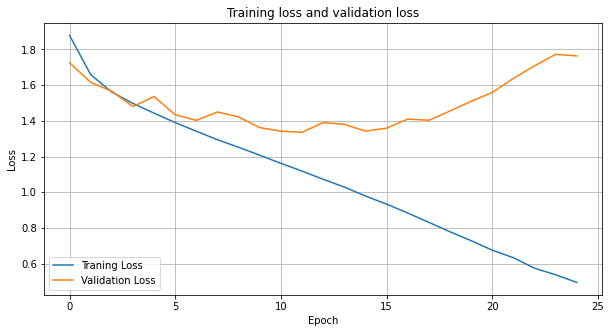

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss and validation loss')
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(("Traning Loss", "Validation Loss"))
plt.grid(True)

### Run your network on some images to get predictions (**PROVIDED**)

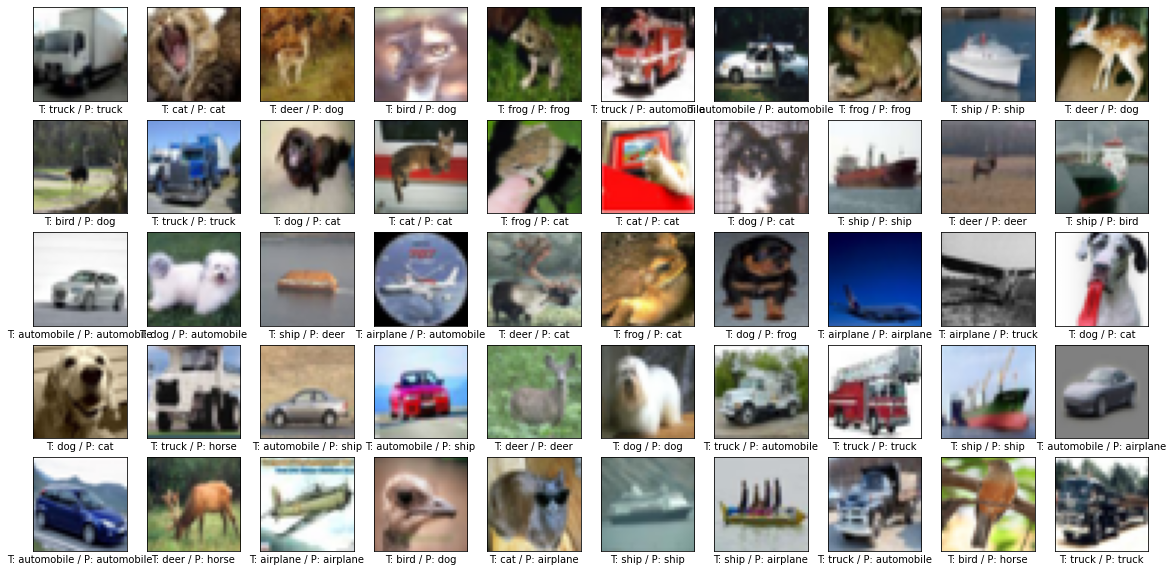

In [ ]:
# select 50 images randomly from the test set and run them through the MLP

plt.figure(figsize=(20,10))

# 50 random images
indices = np.arange(len(testSamples))
np.random.shuffle(indices)
count=0
for i in indices[0:50]:
    plt.subplot(5,10,count+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(testSamples[i], cmap=plt.cm.binary)

    # predict MLP (need to reshape 32 x 32 x 3 pixels -> 1 x 3072 pixels)
    #prediction = model.predict(testSamples[i].reshape(1,32*32*3))
    prediction = model.predict(np.expand_dims(testSamples[i],axis=0))

    # visualize true and predicted labels
    groundTruthLabel = classNames[np.argmax(testLabels[i])]
    predictedLabel   = classNames[np.argmax(prediction)]
    plt.xlabel("T: {} / P: {}".format(groundTruthLabel, predictedLabel))
    count = count+1
plt.show()